# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [24]:
img = X_train[0]

In [33]:
first_image_features = []

In [34]:
first_image_features.append(hog_feature(img))
first_image_features.append(color_histogram_hsv(img))

In [49]:
nbin=10
xmin=0
xmax=255
normalized=True
ndim = img.ndim
bins = np.linspace(xmin, xmax, nbin+1)

(32, 32, 3)

In [59]:
hsv = matplotlib.colors.rgb_to_hsv(img/xmax) * xmax

In [61]:
imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)

In [71]:
bin_edges
np.diff(bin_edges)

array([25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5])

(array([0.03921569, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

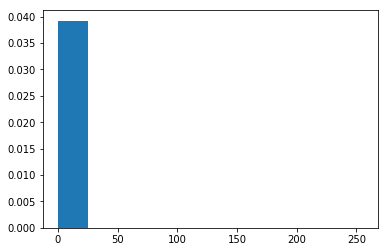

In [68]:
plt.hist(imhist,bins=bin_edges,density=True)

In [40]:
def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):
  ndim = im.ndim
  bins = np.linspace(xmin, xmax, nbin+1)
  hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
  imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)
  imhist = imhist * np.diff(bin_edges)

  # return histogram
  return imhist

(154,)

In [81]:
hog_feature(img).shape

(4, 4, 9)


(144,)

In [78]:
X_train[...,0].shape

(49000, 32, 32)

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
X_train.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for l in learning_rates:
    for r in regularization_strengths:
        print("new search begin:")
        cv_svm = LinearSVM()
        cv_svm.train(X_train_feats, y_train, learning_rate=l, reg=r,
                      num_iters=1500, verbose=True)
        y_train_pred = cv_svm.predict(X_train_feats)
        y_val_pred = cv_svm.predict(X_val_feats)
        train_score = np.mean(y_train == y_train_pred)
        val_score = np.mean(y_val == y_val_pred)
        results[(l,r)] = (train_score, val_score)

        if val_score > best_val:
            best_val = val_score
            best_svm = cv_svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

new search begin:
iteration 0 / 1500: loss 87.138851
iteration 100 / 1500: loss 85.591592
iteration 200 / 1500: loss 84.069037
iteration 300 / 1500: loss 82.595077
iteration 400 / 1500: loss 81.146049
iteration 500 / 1500: loss 79.693268
iteration 600 / 1500: loss 78.321116
iteration 700 / 1500: loss 76.920235
iteration 800 / 1500: loss 75.573449
iteration 900 / 1500: loss 74.278456
iteration 1000 / 1500: loss 72.971152
iteration 1100 / 1500: loss 71.702274
iteration 1200 / 1500: loss 70.463458
iteration 1300 / 1500: loss 69.248552
iteration 1400 / 1500: loss 68.061645
new search begin:
iteration 0 / 1500: loss 790.226985
iteration 100 / 1500: loss 648.542856
iteration 200 / 1500: loss 532.561967
iteration 300 / 1500: loss 437.608592
iteration 400 / 1500: loss 359.880741
iteration 500 / 1500: loss 296.249047
iteration 600 / 1500: loss 244.157243
iteration 700 / 1500: loss 201.509565
iteration 800 / 1500: loss 166.601080
iteration 900 / 1500: loss 138.020892
iteration 1000 / 1500: loss 

In [8]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.415


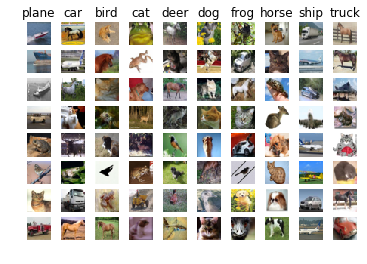

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [16]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates = [1e-7, 5e-7,1e-2,1e-3]
regularization_strengths = [2e3,1e1,0.4,0.5,0.6]
for l in learning_rates:
    for r in regularization_strengths:
        print("new search begin:")
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=l, learning_rate_decay=0.95,
            reg=r, verbose=True)
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        if val_acc > best_val:
            best_val = val_acc
            best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

new search begin:
iteration 0 / 2000: loss 3.126558
iteration 100 / 2000: loss 3.095816
iteration 200 / 2000: loss 3.066236
iteration 300 / 2000: loss 3.038513
iteration 400 / 2000: loss 3.012418
iteration 500 / 2000: loss 2.987359
iteration 600 / 2000: loss 2.964271
iteration 700 / 2000: loss 2.941961
iteration 800 / 2000: loss 2.921082
iteration 900 / 2000: loss 2.901255
iteration 1000 / 2000: loss 2.882242
iteration 1100 / 2000: loss 2.864574
iteration 1200 / 2000: loss 2.847445
iteration 1300 / 2000: loss 2.831444
iteration 1400 / 2000: loss 2.816118
iteration 1500 / 2000: loss 2.801450
iteration 1600 / 2000: loss 2.787707
iteration 1700 / 2000: loss 2.774342
iteration 1800 / 2000: loss 2.761885
iteration 1900 / 2000: loss 2.749856
new search begin:
iteration 0 / 2000: loss 2.306657
iteration 100 / 2000: loss 2.306656
iteration 200 / 2000: loss 2.306655
iteration 300 / 2000: loss 2.306654
iteration 400 / 2000: loss 2.306654
iteration 500 / 2000: loss 2.306653
iteration 600 / 2000: 

C:\Users\Administrator\Desktop\斯坦福C231N ppt\assignment1\cs231n\classifiers\neural_net.py:104: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(scores[range(N),y]))/N + 0.5 * reg * np.sum(W1*W1)+ 0.5 * reg * np.sum(W2*W2)


iteration 100 / 2000: loss inf


C:\Users\Administrator\Desktop\斯坦福C231N ppt\assignment1\cs231n\classifiers\neural_net.py:104: RuntimeWarning: overflow encountered in double_scalars
  loss = -np.sum(np.log(scores[range(N),y]))/N + 0.5 * reg * np.sum(W1*W1)+ 0.5 * reg * np.sum(W2*W2)
C:\Users\Administrator\Desktop\斯坦福C231N ppt\assignment1\cs231n\classifiers\neural_net.py:101: RuntimeWarning: overflow encountered in subtract
  l2 -= max_column
C:\Users\Administrator\Desktop\斯坦福C231N ppt\assignment1\cs231n\classifiers\neural_net.py:101: RuntimeWarning: invalid value encountered in subtract
  l2 -= max_column
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Administrator\Desktop\斯坦福C231N ppt\assignment1\cs231n\classifiers\neural_net.py:79: RuntimeWarning: invalid value encountered in maximum
  a1 = np.maximum(l1,0)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packa

iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
new search begin:
iteration 0 / 2000: loss 2.306704
iteration 100 / 2000: loss 2.302581
iteration 200 / 2000: loss 2.302157
iteration 300 / 2000: loss 2.302496
iteration 400 / 2000: loss 2.302188
iteration 500 / 2000: loss 2.301728
iteration 600 / 2000: loss 2.302284
iteration 700 / 2000: loss 2.303205
iteration 800 / 2000: loss 2.302765
iteration 900 / 2000: loss 2.302716
iteration 1000 / 2000: loss 2.302378
iteration 1100 / 20

In [17]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.11
